# Injector-Producer Connectivity Analysis using CRM
**Author:** Ade Anggi Naluriawan Santoso | **Project:** Spatial Analysis and Connectivity

### Objective
This notebook demonstrates the implementation of the **Capacitance Resistance Model (CRMP)** to quantify the connectivity between 10 injectors and 40 producers. 

We will use `scipy.optimize` to inverse-solve the reservoir parameters ($\tau$ and $f_{ij}$) that best fit the historical production data given the injection history.

### The CRMP Equation
The discretized form of the Continuity Equation used here is:

$$q_j(t) = q_j(t-1) e^{-\frac{1}{\tau_j}} + \sum_{i=1}^{N_{inj}} f_{ij} (1 - e^{-\frac{1}{\tau_j}}) I_i(t)$$

Where:
* $q_j(t)$: Predicted Production Rate at time $t$
* $I_i(t)$: Injection Rate of injector $i$ at time $t$
* $\tau_j$: Time constant for producer $j$
* $f_{ij}$: Connectivity weight (fraction of injection $i$ supporting producer $j$)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from datetime import timedelta

# Plotting style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Load Data
df = pd.read_csv('production_injection_data.csv', parse_dates=['Date'], index_col='Date')

# Separate Injectors and Producers
inj_cols = [c for c in df.columns if c.startswith('I')]
prod_cols = [c for c in df.columns if c.startswith('P')]

X_inj = df[inj_cols].values
Y_prod = df[prod_cols].values

print(f"Loaded data: {len(df)} days")
print(f"Injectors: {len(inj_cols)}, Producers: {len(prod_cols)}")

df.head()

Loaded data: 1000 days
Injectors: 10, Producers: 40


,I01,I02,I03,I04,I05,I06,I07,I08,I09,I10,...,P31,P32,P33,P34,P35,P36,P37,P38,P39,P40
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,1149.014246,958.520710,1194.306561,1456.908957,929.753988,929.758913,1473.763845,1230.230419,859.157684,1162.768013,...,850.931213,613.595627,502.050725,671.467558,984.429668,847.483730,700.662722,596.288049,678.044837,584.919717
2020-01-02,860.974692,860.281074,1072.588681,426.015927,482.524650,831.313741,696.150664,1094.274200,727.592777,576.308890,...,848.144929,591.022542,494.048496,661.644645,978.509510,848.121391,688.039141,591.193066,662.522574,596.229068
2020-01-03,1439.694631,932.267110,1020.258461,572.575544,836.685183,1033.276777,654.701927,1112.709406,819.808393,912.491875,...,845.866761,592.136919,483.663099,666.222761,993.230179,855.469033,680.087105,589.104755,656.899005,609.249367
2020-01-04,819.488016,1555.683455,995.950833,682.686721,1246.763474,633.746905,1062.659079,412.098963,601.544185,1059.058371,...,831.040110,594.884684,483.253536,676.095870,984.916132,853.936431,662.017033,576.969754,652.394331,609.783502
2020-01-05,1221.539974,1051.410484,965.305515,909.668891,556.443403,784.046737,861.808369,1317.136668,1103.085487,471.087953,...,824.598239,588.136883,488.187740,687.608995,976.556855,860.646414,647.985276,568.441112,643.194673,626.757406


## 1. Define the Physics Model (CRMP)

We define a function `simulate_production` that takes specific values of `tau` and `gains` ($f_{ij}$) and reconstructs the production profile based on the injection history.

**Note:** To ensure numerical stability during optimization, we constrain $\tau > 0$ and $0 \le f_{ij} \le 1$.

In [2]:
def simulate_crm_production(tau, gains, injection_data, initial_production):
    """
    Simulates production for a SINGLE producer based on CRMP physics.
    
    Args:
        tau (float): Time constant
        gains (np.array): Array of connectivity weights (f_ij) for all injectors
        injection_data (np.array): Matrix of injection rates (Time x N_injectors)
        initial_production (float): The starting production rate q(t=0)
        
    Returns:
        np.array: Predicted production rates over time
    """
    n_steps, n_inj = injection_data.shape
    q_pred = np.zeros(n_steps)
    
    # Pre-calculate decay factors
    decay = np.exp(-1.0 / tau)
    inv_decay = 1.0 - decay
    
    # Set initial rate
    q_pred[0] = initial_production
    
    # Iterative calculation (Vectorized for injectors, iterative for time)
    # q(t) = q(t-1)*decay + sum(gains * inj(t)) * (1-decay)
    
    # Calculate the weighted injection term for all timesteps at once to speed up loop
    # weighted_I[t] = sum(f_ij * I_i(t))
    weighted_I = np.dot(injection_data, gains) 
    
    for t in range(1, n_steps):
        q_pred[t] = q_pred[t-1] * decay + weighted_I[t] * inv_decay
        
    return q_pred

## 2. Define Objective Function

We use the **Sum of Squared Errors (SSE)** as our objective function. The optimizer will adjust `tau` and `gains` to minimize this value.

$$SSE = \sum_{t} (q_{obs}(t) - q_{pred}(t))^2$$

In [3]:
def objective_function(params, injection_data, observed_production):
    """
    Loss function for scipy.optimize.
    Params vector structure: [tau, f_1, f_2, ..., f_n]
    """
    tau = params[0]
    gains = params[1:]
    
    # Physics Constraint Handling:
    # Although bounds handle this, adding a penalty prevents NaN in calculation if boundaries are breached
    if tau <= 0.01: return 1e9
    
    initial_prod = observed_production[0]
    
    # Simulate
    q_pred = simulate_crm_production(tau, gains, injection_data, initial_prod)
    
    # Calculate SSE
    sse = np.sum((observed_production - q_pred)**2)
    return sse

## 3. Run Optimization (Fit the Model)

We iterate through all 40 producers. For each producer, we run `scipy.optimize.minimize` to find the best `tau` and `f_ij` values.

**Bounds:**
* Tau: [1, 100] days (Assumed physical range)
* Gains: [0, 1] (Physical connectivity cannot be negative)

In [4]:
results_tau = {}
results_gains = []

print("Starting CRM Optimization for 40 Producers...")

for i, p_name in enumerate(prod_cols):
    # Prepare data for this specific producer
    obs_q = df[p_name].values
    
    # Initial Guesses
    # Tau = 10 days, Gains = 1/N_injectors (equal distribution initially)
    init_tau = 10.0
    init_gains = np.ones(len(inj_cols)) / len(inj_cols)
    initial_guess = np.concatenate(([init_tau], init_gains))
    
    # Bounds: Tau (1 to 200), Gains (0 to 1)
    bounds = [(1.0, 200.0)] + [(0.0, 1.0) for _ in range(len(inj_cols))]
    
    # Optimization
    res = minimize(
        objective_function, 
        initial_guess, 
        args=(X_inj, obs_q), 
        method='L-BFGS-B', 
        bounds=bounds
    )
    
    # Store results
    best_tau = res.x[0]
    best_gains = res.x[1:]
    
    results_tau[p_name] = best_tau
    
    # Create a dictionary for this producer's gains
    producer_gains = {'Producer': p_name}
    for idx, inj_name in enumerate(inj_cols):
        producer_gains[inj_name] = best_gains[idx]
    results_gains.append(producer_gains)
    
    if (i+1) % 5 == 0:
        print(f"Processed {i+1}/40: {p_name} (Tau: {best_tau:.2f})")

print("Optimization Complete.")

Starting CRM Optimization for 40 Producers...
Processed 5/40: P05 (Tau: 43.77)
Processed 10/40: P10 (Tau: 47.97)
Processed 15/40: P15 (Tau: 19.17)
Processed 20/40: P20 (Tau: 11.57)
Processed 25/40: P25 (Tau: 23.66)
Processed 30/40: P30 (Tau: 25.75)
Processed 35/40: P35 (Tau: 36.86)
Processed 40/40: P40 (Tau: 43.81)
Optimization Complete.


## 4. Visualization of Results

### A. Connectivity Map (Heatmap)
This heatmap shows the strength of the connection ($f_{ij}$) between every Injector-Producer pair. Darker/Brighter colors indicate strong connectivity.

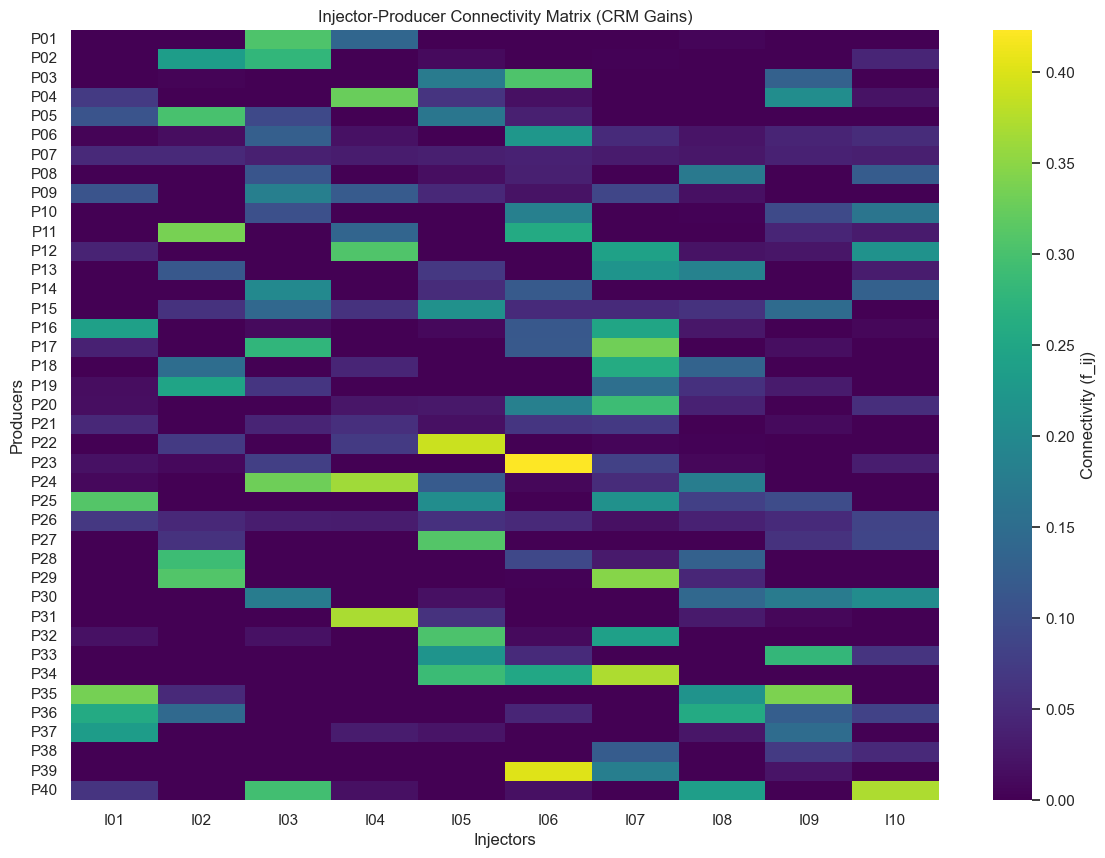

In [5]:
# Convert results to DataFrame
df_gains = pd.DataFrame(results_gains).set_index('Producer')

plt.figure(figsize=(14, 10))
sns.heatmap(df_gains, cmap='viridis', annot=False, cbar_kws={'label': 'Connectivity (f_ij)'})
plt.title('Injector-Producer Connectivity Matrix (CRM Gains)')
plt.xlabel('Injectors')
plt.ylabel('Producers')
plt.show()

### B. History Match Validation
Let's select one producer and verify how well our trained CRM model (orange line) matches the actual historical data (blue line).

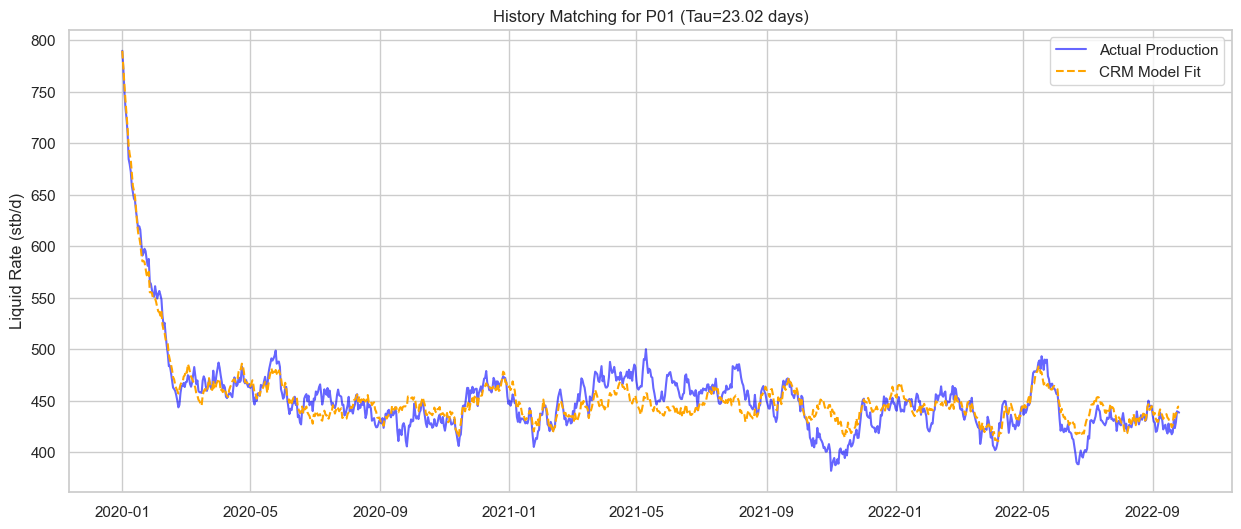

In [6]:
# Pick a random producer to visualize
target_prod = prod_cols[0] # Change index to see others (e.g., prod_cols[5])

# Retrieve optimized params
opt_tau = results_tau[target_prod]
opt_gains = df_gains.loc[target_prod].values

# Re-simulate using optimized params
q_actual = df[target_prod].values
q_model = simulate_crm_production(opt_tau, opt_gains, X_inj, q_actual[0])

# Plot
plt.figure(figsize=(15, 6))
plt.plot(df.index, q_actual, label='Actual Production', alpha=0.6, color='blue')
plt.plot(df.index, q_model, label='CRM Model Fit', color='orange', linestyle='--')
plt.title(f'History Matching for {target_prod} (Tau={opt_tau:.2f} days)')
plt.ylabel('Liquid Rate (stb/d)')
plt.legend()
plt.show()

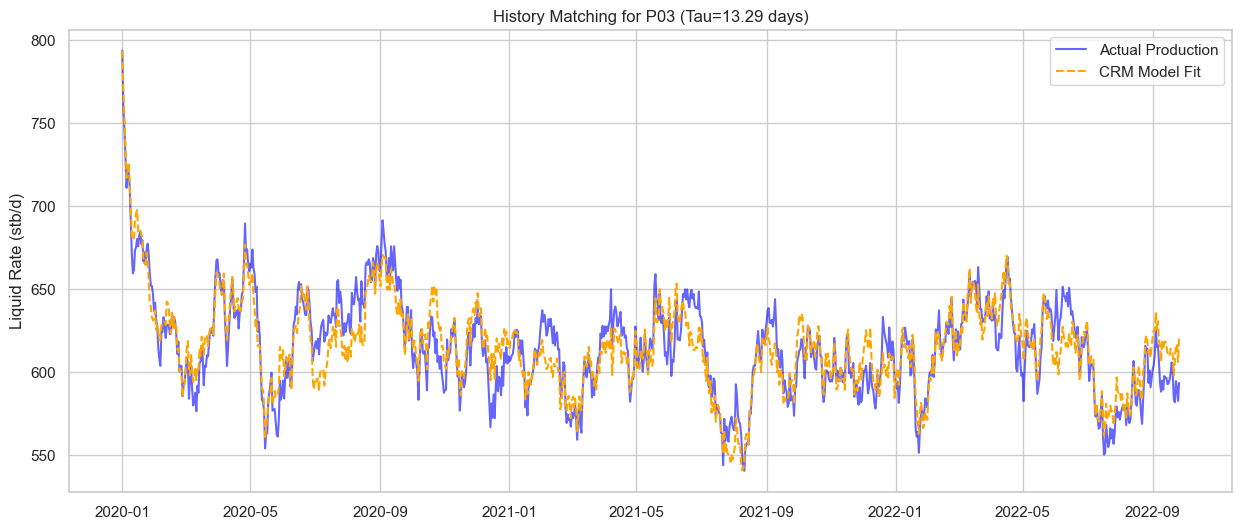

In [7]:
# Pick a random producer to visualize
target_prod = prod_cols[2] # Change index to see others (e.g., prod_cols[5])

# Retrieve optimized params
opt_tau = results_tau[target_prod]
opt_gains = df_gains.loc[target_prod].values

# Re-simulate using optimized params
q_actual = df[target_prod].values
q_model = simulate_crm_production(opt_tau, opt_gains, X_inj, q_actual[0])

# Plot
plt.figure(figsize=(15, 6))
plt.plot(df.index, q_actual, label='Actual Production', alpha=0.6, color='blue')
plt.plot(df.index, q_model, label='CRM Model Fit', color='orange', linestyle='--')
plt.title(f'History Matching for {target_prod} (Tau={opt_tau:.2f} days)')
plt.ylabel('Liquid Rate (stb/d)')
plt.legend()
plt.show()